# **Control de temperatura en edificaciones - Control on/off y Logica difusa**

NICOLAS GARZON RODRIGUEZ

# **Controlador ON/OFF**


#### Definición

El controlador on/off es una estrategia de control discreta que actúa de forma binaria: enciende o apaga el actuador dependiendo de si la variable controlada está por debajo o por encima del setpoint definido.

Se importan las librerias necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

En primer lugar se definen los parametros del sistema: los cuales son la capacidad termica de cada salon c, el coeficiente de transferencia de calor entre salon alpha, la temperatura ambiente T_a (la cual se tomara como condicion inicial para los 4 salones) y para la señal escalon se define un valor maximo de 5000 W por salon

In [ ]:
c = 7.476e4
alpha = 123.6
T_a = 8
potencia_maxima = 5000

Se definen las matrices que representan las dinamicas del sistema

In [ ]:
A = np.array([
    [-2*alpha/c, alpha/c, 0, 0],
    [alpha/c, -3*alpha/c, alpha/c, 0],
    [0, alpha/c, -3*alpha/c, alpha/c],
    [0, 0, alpha/c, -2*alpha/c]
])
B = np.array([
    [1/c, 0, 0, 0, alpha/c],
    [0, 1/c, 0, 0, alpha/c],
    [0, 0, 1/c, 0, alpha/c],
    [0, 0, 0, 1/c, alpha/c]
])
C = np.eye(4)
D = np.zeros_like(B)

Posteriormente se definen las condiciones iniciales del sistema y los setpoints por salon, que en este caso es una temperatura de 22 grados para los 4 salones

In [ ]:
T_ref = [22, 21, 20, 19]
x = np.array([8, 8, 8, 8])


## Implementacion inicial de controlador ON/OFF

Para el controlador se define las siguiente funcion, si la temperatura esta por debajo del setpoint la calefaccion se activa y si la temperatura es igual o mayor que el setpoint se desactiva

In [ ]:
def controlador_on_off(temp_actual, temp_ref, potencia_maxima):
    return potencia_maxima if temp_actual < temp_ref else 0

Luego se define el tiempo se simulacion y el paso de integración, para la primera implementacion del controlador se consideraran las dinamicas de manera discreta.

In [ ]:
t = np.linspace(0, 3600, 1000)
dt = t[1] - t[0]

Para la simulación del sistema se calcula la calefaccion de cada uno de los salones, se aplica el modelo dinamico para actualizar las temperaturas y se guardan los datos para el posterior analisis

In [ ]:
temperaturas = []
actuadores = []


for ti in t:

    u = [controlador_on_off(x[i], T_ref[i], potencia_maxima) for i in range(4)]
    u.append(T_a)
    temperaturas.append(x.copy())
    actuadores.append([ui > 0 for ui in u[:4]])
    dx = A @ x + B @ np.array(u)
    x = x + dx * dt

temperaturas = np.array(temperaturas)
actuadores = np.array(actuadores)


#### Grafica de las temperaturas

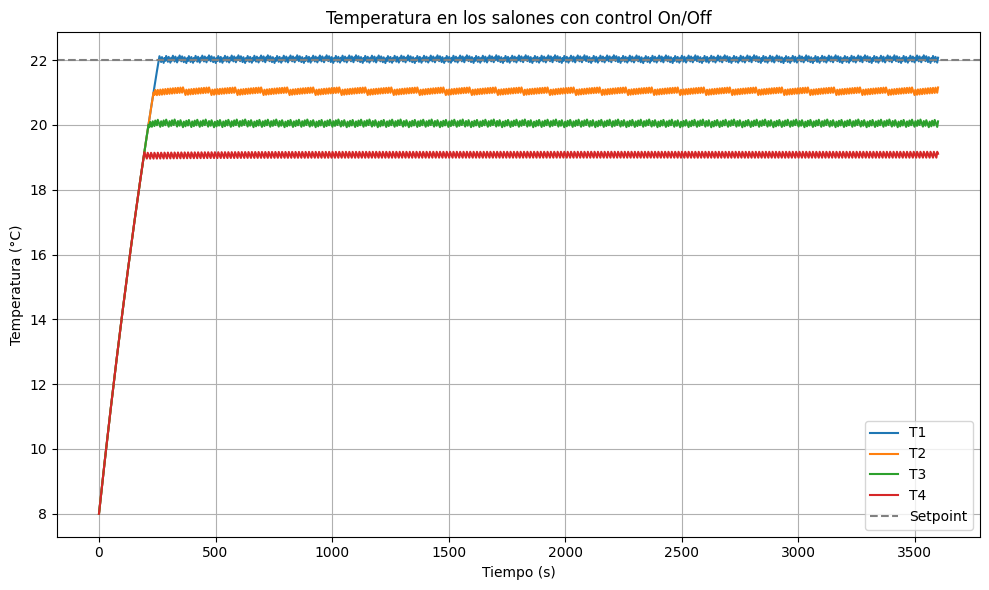

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(t, temperaturas[:, i], label=f'T{i+1}')
plt.axhline(22, color='gray', linestyle='--', label='Setpoint')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura en los salones con control On/Off')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Al analizar la grafica de temperatura vemos como en un principio las temperaturas de los 4 salones se encuentran por debajo del setpoint definido, esto hace que se activen los actuadores (calefacción) provocando que las temperaturas suban hasta que las 4 alcanzan el setpoint definido y que se apaguen los actuadores.

Esto genera una leve caida de temperatura que provoca que los actuadores se vuelvan a encender haciendo que la temperatura sobrepase el setpoint y a partir de ese punto se comienzan a presentar oscilaciones alrededor de este valor durante el resto de la simulación.

Este comportamiento es esperado de un controlador ON/OFF, ya que solo puede encender o apagar dependiendo de la temperatura de cada uno de los salones.

#### Grafica de los actuadores

Al graficar los datos de toda la simulación se logra ver el comportamiento de los 4 actuadores aunque por la cantidad de informacion no se logra observar con claridad, el siguiente codigo permite graficar un intervalo menor de los datos para visualizar mejor el comportamiento.

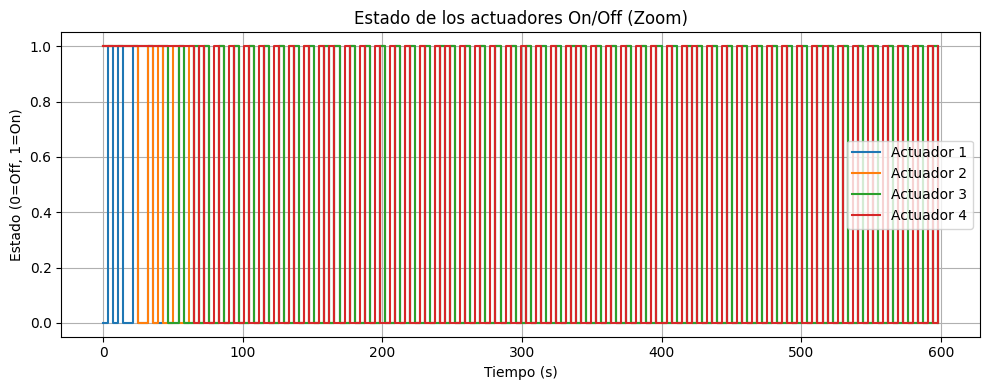

In [ ]:
t_inicio = 0
t_fin = 600

indices = (t >= t_inicio) & (t <= t_fin)
t_zoom = t[indices]
actuadores_intervalo = actuadores[indices]

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.step(t_zoom, actuadores_intervalo[:, i], where='post', label=f'Actuador {i+1}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Estado (0=Off, 1=On)')
plt.title('Estado de los actuadores On/Off (Zoom)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En esta grafica se puede ver con mayor claridad la frecuencia de activacion de cada uno de los actuadores, mostrando un comportamiento esperado de un controlador ON/OFF

## Implementacion de controlador ON/OFF con histeresis

 Partiendo de la base del controlador definido anteriormente y los resultados obtendios se realizara la implementación de otro controlador ON/OFF aplicando  histeresis como tecnica adicional buscando una respuesta mas estable.


### Definición de histeresis


Es un fenomeno de sistemas de control donde la respuesta del controlador no depende unicamente del valor actual de la variable sino tambien de los estados anteriores. Dentro del contexto del control de temperatura, esta implementacion puede prevenir que la calefacción se encienda y se apague constantemente cuando la temperatura se encuentre cerca al setpoint.

### Implementación

En primer lugar, se importa la liberia odeint para realizar la simulación detallada del sistema a diferencia de la primera implementacion donde se consideraron las dinamicas de forma disctretizada. Se define una nueva funcion para el controlador ON/OFF donde en primera instancia se valida si la calefaccion se encuentra encendido para luego aplicar una de las siguientes reglas:

*   Si estaba encendido, se permite que siga encendido hasta que la temperatura supere el setpoint + tolerancia.
*  Si estaba apagado, se permite que se encienda solo si la temperatura cae por debajo del setpoint − tolerancia.


La tolerancia es un parametro adicional de esta implementacion, posteriormente se mostrara el efecto de esta variable sobre los resultados del controlador.



In [ ]:
from scipy.integrate import odeint
def controlador_on_off_histeresis(temp_actual, temp_ref, estado_anterior, tolerancia):
    if estado_anterior:
        return potencia_maxima if temp_actual < temp_ref + tolerancia else 0
    else:
        return potencia_maxima if temp_actual < temp_ref - tolerancia else 0

Posteriormente se define una funcion para representar la dinamica del sistema con el control aplicado a los 4 salones. Como parametro la funcion recibe la temperatura actual y el setpoint de los salones, la potencia maxima definida anteriormente (5000w) y la tolerancia que utilizara el controlador.


Esta funcion retorna un vector que representa la tasa de cambio de las temperaturas de cada salon.

In [ ]:
def sistema_termico(x, t, T_ref, potencia_maxima, tolerancia):
    global estado_actuadores
    u = []
    for i in range(4):
        potencia = controlador_on_off_histeresis(x[i], T_ref[i], estado_actuadores[i], tolerancia)
        estado_actuadores[i] = potencia > 0
        u.append(potencia)
    u.append(T_a)
    dxdt = A @ x + B @ np.array(u)
    return dxdt

Para la simulacion se define el tiempo, las condiciones iniciales (temperatura ambiente para los 4 salones y los actuadores apagados). Ademas, se define una tolerancia de 0.1°C buscando que la temperatura se mantenga lo mas cercana posible al setpoint.

In [ ]:
# Tiempo de simulación y parametros
t = np.linspace(0, 3600, 1000)
tolerancia = 0.1
x0 = [T_a] * 4
estado_actuadores = [False] * 4

#Simulación
sol = odeint(sistema_termico, x0, t, args=(T_ref, potencia_maxima, tolerancia))

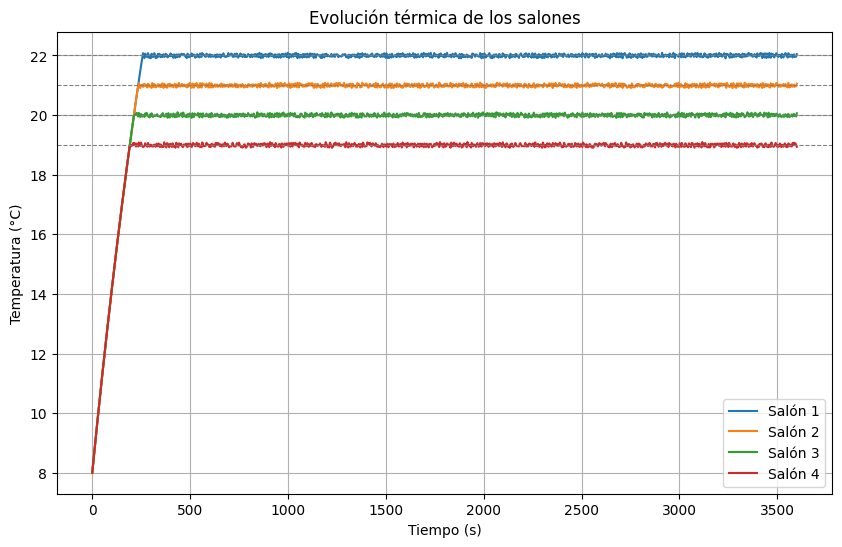

In [ ]:
plt.figure(figsize=(10,6))
for i in range(4):
    plt.plot(t, sol[:, i], label=f'Salón {i+1}')
    plt.axhline(T_ref[i], color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Evolución térmica de los salones')
plt.legend()
plt.grid()
plt.show()


En la grafica anterior podemos observar como la temperatrua de los 4 salones sube rapidamente hasta llegar al setpoint y a partir de ahi se presentan unas oscilaciones frecuentes pero con una baja amplitud. Esto significa que a la temperatura logra mantenerse cercana a las referencias definidas de los 4 salones.

Con el fin de mostrar el efecto que tiene la tolerancia en el controlador ON/OFF con histeresis se realiza otra simulacion esta vez con una tolerancia de 1°C.

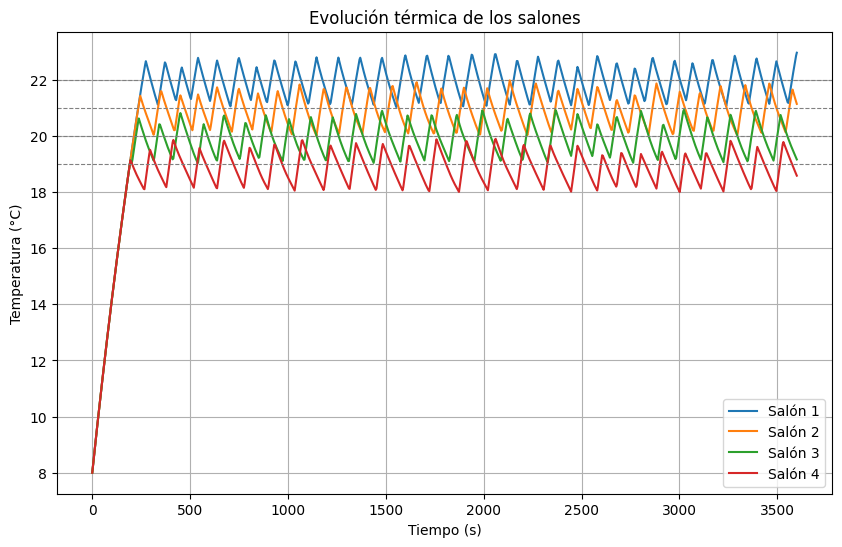

In [ ]:
# Tiempo de simulación y parametros
t = np.linspace(0, 3600, 1000)
tolerancia = 1
x0 = [T_a] * 4
estado_actuadores = [False] * 4

#Simulación
sol = odeint(sistema_termico, x0, t, args=(T_ref, potencia_maxima, tolerancia))
plt.figure(figsize=(10,6))
for i in range(4):
    plt.plot(t, sol[:, i], label=f'Salón {i+1}')
    plt.axhline(T_ref[i], color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Evolución térmica de los salones')
plt.legend()
plt.grid()
plt.show()


En la grafica se puede ver como las temperaturas de los 4 salones presentan oscliaciones de mayor amplitud alrededor del setpoint aunque con una menor frecuencia como resultado del cambio en la tolerancia.

### Conclusiones

De los resultados obtenidos se puede concluir que el sistema logra mantener la temperatura cerca del setpoint definido aunque con unas pequeñas fluctuaciones. El controlador ON/OFF resulta ser simple y efectivo para este sistema aunque no la alternativa mas optima en terminos de eficiencia energetica.

Al implementar el controlador con histeriris se logro evidenciar un cambio importante con dos comportamientos marcados por el valor definido para la tolerancia, cuando se definio un valor bajo se obtuvo un comportamiento estable y suave con oscilaciones de una baja amplitud pero con una mayor frecuencia mientras que con una tolerancia mayor la frecuencia disminuyo pero las oscilaciones fueron de una mayor amplitud.

Entre las dos alternativas consideradas y teniendo en cuenta el contexto de la implementación se puede concluir que es una mejor opcion el controlador con histeresis con una tolerancia de 0.1°C que priorice la precision termica a pesar que esto pueda representar un mayor desgaste de los actuadores por una mayor frecuencia en los cambios de temperatura.

# **Controlador Lógica Difusa**





#### Definicion logica difusa

La lógica difusa es una lógica multivaluada en la que los valores de verdad pueden variar entre 0 y 1, en lugar de ser únicamente verdadero o falso como ocurre en un controlador ON/OFF.

#### Importación de librerias 

A diferencia de la implementacion del controlador ON/OFF, para la implementacion de este controlador se debe instalar la libreria scikit-fuzzy la cual permite trabajar con logica difusa.

In [ ]:
pip install -U scikit-fuzzy

Luego de la instalacion se importan las librerias adicionales para la implementacion del controlador

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

#### Definicion de variables

Para comenzar, se definieron como variables de entrada el error termico promedio y el cambio de error termico mientras que como variable de salida se establecio la potencia total que el controlador puede aplicar.

#### Variable de entrada: Error térmico promedio

Esta variable corresponde a la diferencia entre la temperatura de referencia y la temperatura acutal promedio de los 4 salones. Se definieron 7 etiquetas linguisticas:

- **mucho_calor**, **calor**, **leve_calor**: indican que el sistema está por encima de la referencia.  
- **neutro**: represena una condicion cercana al equilibiro.  
- **leve_frio**, **frio**, **mucho_frio**: indican que el sistema está por debajo de la referencia.

Se definieron de esta manera para lograr cubrir un rango de ±10 °C de tal manera que el controlador pueda reaccionar tanto ante el sobrecalentamiento como ante el enfriamiento y con un ordenamiento gradual de las etiquetas pata permitir transiciones suaves entro los estados evitando respuestas bruscas

c:\Users\Nicolas Garzon\MAIA\.venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


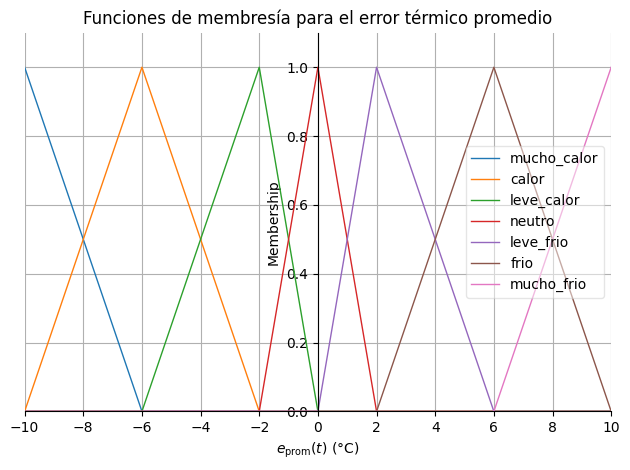

In [ ]:
# Funciones de membresía
error_termico_prom = ctrl.Antecedent(np.arange(-10, 10.1, 0.1), 'error térmico promedio')
etiquetas_error = ['mucho_calor', 'calor', 'leve_calor', 'neutro', 'leve_frio', 'frio', 'mucho_frio']
error_termico_prom['mucho_calor'] = fuzz.trimf(error_termico_prom.universe, [-10, -10, -6])
error_termico_prom['calor'] = fuzz.trimf(error_termico_prom.universe, [-10, -6, -2])
error_termico_prom['leve_calor'] = fuzz.trimf(error_termico_prom.universe, [-6, -2, 0])
error_termico_prom['neutro'] = fuzz.trimf(error_termico_prom.universe, [-2, 0, 2])
error_termico_prom['leve_frio'] = fuzz.trimf(error_termico_prom.universe, [0, 2, 6])
error_termico_prom['frio'] = fuzz.trimf(error_termico_prom.universe, [2, 6, 10])
error_termico_prom['mucho_frio'] = fuzz.trimf(error_termico_prom.universe, [6, 10, 10])

error_termico_prom.view()
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim(-10, 10)
ax.set_ylim(0, 1.1)
plt.xticks(np.arange(-10, 11, 2))
ax.set_xlabel(r'$e_{\mathrm{prom}}(t)$ (°C)')
plt.title("Funciones de membresía para el error térmico promedio")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Variable de entrada: Cambio del error térmico promedio


Esta variable representa la velocidad con la que cambia el error termico, es decir representa si el sistema se esta calentando/enfriando y con que rapidez. Se definieron las siguinetes etiquetas:

- **enfriando_rapido**, **enfriando_lento**: el error está disminuyendo, es decir que la temperatura esta bajando.  
- **estable**: el error se mantiene constante.  
- **calentando_lento**, **calentando_rapido**: el error está aumentando, es decir que la temperatura esta subiendo.

Se definio un rango de ±0.1 °C/s para lograr representar dinamicas realistas del sistema y utilizando funciones de membresia de  tipo zmf, smf y trimf es posible representar comportamientos extremos y las transisciones del sistema.



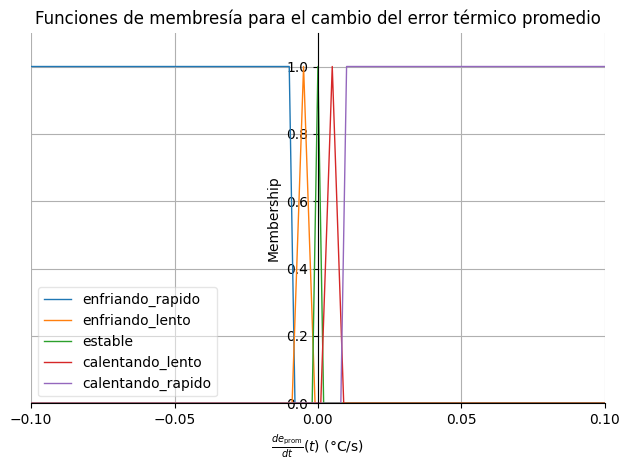

In [ ]:
cambio_error_termico = ctrl.Antecedent(np.arange(-0.1, 0.101, 0.001), 'cambio del error térmico promedio')
etiquetas_cambio_error = ['enfriando_rapido', 'enfriando_lento', 'estable', 'calentando_lento', 'calentando_rapido']
cambio_error_termico['enfriando_rapido'] = fuzz.zmf(cambio_error_termico.universe, -0.01, -0.008)
cambio_error_termico['enfriando_lento'] = fuzz.trimf(cambio_error_termico.universe, [-0.009, -0.005, -0.001])
cambio_error_termico['estable'] = fuzz.trimf(cambio_error_termico.universe, [-0.002, 0, 0.002])
cambio_error_termico['calentando_lento'] = fuzz.trimf(cambio_error_termico.universe, [0.001, 0.005, 0.009])
cambio_error_termico['calentando_rapido'] = fuzz.smf(cambio_error_termico.universe, 0.008, 0.01)

cambio_error_termico.view()
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(0, 1.1)
plt.xticks(np.arange(-0.1, 0.11, 0.05))
ax.set_xlabel(r'$\frac{de_{\mathrm{prom}}}{dt}(t)$ (°C/s)')
plt.title("Funciones de membresía para el cambio del error térmico promedio")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Variable de salida: Potencia total

Esta variable representa la potencia total que el controlador puede apicar en el sistema. Se definieron las siguientes etiquetas con el fin de abarcar una mayor cantidad de posibilidades:

- **nula**, **baja**, **media**, **alta**, **maxima**

En primer lugar, se establecio un valor maximo de 12000 W para asegurar que el sistema sea capaz de alcanzar el setpoint establecido para los 4 salones. Por otro lado, las funciones de mebresia se definieron de tal manera que se solapen entre si para permitir combinaciones suaves entre las reglas activadas.



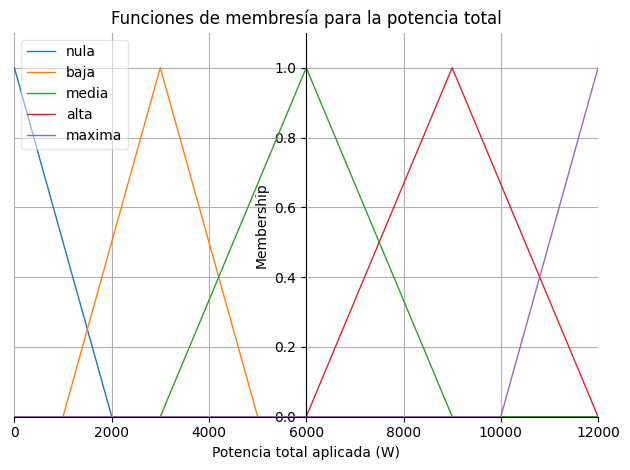

In [ ]:
potencia_total = ctrl.Consequent(np.arange(0, 12001, 1), 'potencia_total')
potencia_total['nula'] = fuzz.trimf(potencia_total.universe, [0, 0, 2000])
potencia_total['baja'] = fuzz.trimf(potencia_total.universe, [1000, 3000, 5000])
potencia_total['media'] = fuzz.trimf(potencia_total.universe, [3000, 6000, 9000])
potencia_total['alta'] = fuzz.trimf(potencia_total.universe, [6000, 9000, 12000])
potencia_total['maxima'] = fuzz.trimf(potencia_total.universe, [10000, 12000, 12000])

potencia_total.view()
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim(0, 12000)
ax.set_ylim(0, 1.1)
plt.xticks(np.arange(0, 12001, 2000))
ax.set_xlabel('Potencia total aplicada (W)')
plt.title("Funciones de membresía para la potencia total")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Reglas difusas

La logica establecida para definir las relgas a partir de las variables establecidas fue la siguiente:

- Si el sistema está **muy frío o frío**, se aplica **máxima o alta potencia**, especialmente si el error está creciendo o estable.  
- Si el sistema está **leve_frio**, se aplica **media o alta potencia**, dependiendo de la dinámica.  
- Si el sistema está **neutro**, se aplica **baja o nula potencia**, para evitar sobrecalentamiento.  
- Si el sistema está **caliente o muy caliente**, se aplica **nula potencia**, independientemente de la dinámica.

Este conjunto de reglas se definio de tal manera que el sistema pueda responder al estado actual de la temperatura de los salones como la tendencia que lleva, esto permite mejorar la anticipacion y reducir el error estacionario.

In [ ]:

lista_reglas = []
for etiqueta_error in etiquetas_error:
    for etiqueta_cambio in etiquetas_cambio_error:
        if etiqueta_error in ['mucho_frio', 'frio']:
            salida = 'maxima' if etiqueta_cambio in ['enfriando_rapido', 'enfriando_lento'] else 'media'
            if etiqueta_cambio == 'estable':
                salida = 'alta'

        elif etiqueta_error == 'leve_frio':
            if etiqueta_cambio in ['enfriando_rapido', 'enfriando_lento']:
                salida = 'alta'  
            elif etiqueta_cambio == 'estable':
                salida = 'alta'  
            else:
                salida = 'media'  

        elif etiqueta_error == 'neutro':
            if etiqueta_cambio == 'estable':
                salida = 'media'  
            else:
                salida = 'media'  
        elif etiqueta_error == 'leve_calor':
            salida = 'nula' if etiqueta_cambio in ['calentando_rapido', 'calentando_lento'] else 'baja'
        else:
            salida = 'nula'

        regla = ctrl.Rule(
            error_termico_prom[etiqueta_error] & cambio_error_termico[etiqueta_cambio],
            potencia_total[salida]
        )
        lista_reglas.append(regla)

ctrl_termico = ctrl.ControlSystem(lista_reglas)
sim_termico = ctrl.ControlSystemSimulation(ctrl_termico)

#### Simulación

Para empezar, se definen los parametros fisicos y las matrices que representan el sistema.

In [ ]:
# Parámetros físicos
C = 7.476e4
alpha = 123.6
T_a = 8

A = np.array([
    [-2*alpha/C, alpha/C, 0, 0],
    [alpha/C, -3*alpha/C, alpha/C, 0],
    [0, alpha/C, -3*alpha/C, alpha/C],
    [0, 0, alpha/C, -2*alpha/C]
])
B = np.array([
    [1/C, 0, 0, 0, alpha/C],
    [0, 1/C, 0, 0, alpha/C],
    [0, 0, 1/C, 0, alpha/C],
    [0, 0, 0, 1/C, alpha/C]
])





Se definen las condiciones iniciales (temperatura ambiente para los 4 salones), las temperatruras de referencia y se inicializan las variables de la simulacion. Se definen las variables donde se almacenaran los resultados de la simulacion para la posterior visualización y analisis.

In [ ]:
x = np.array([8, 8, 8, 8])
T_ref = [22, 21, 20, 19]
e_old = 0
T = 1
t = 0
tstop = 3600
step = 1

time = []
temp_hist = []
error_hist = []
potencia_hist = []
potencia_total_hist = []

while t < tstop:
    errores = np.array(T_ref) - x
    error_prom = np.mean(errores)
    cambio_error = (error_prom - e_old) / T
    e_old = error_prom

    sim_termico.input['error térmico promedio'] = error_prom
    sim_termico.input['cambio del error térmico promedio'] = cambio_error
    sim_termico.compute()
    potencia_total_valor = sim_termico.output['potencia_total']
    potencia_total_hist.append(potencia_total_valor)

    errores_positivos = errores > 0
    pesos = np.where(errores_positivos, errores, 0)
    suma_pesos = np.sum(pesos)
    if suma_pesos == 0:
        u_individual = [0, 0, 0, 0]
    else:
        distribucion = potencia_total_valor * pesos / suma_pesos
        u_individual = np.where(errores_positivos, distribucion, 0)

    u = np.concatenate([u_individual, [T_a]])
    dx = A @ x + B @ np.array(u)
    x = x + dx * step

    time.append(t)
    temp_hist.append(x.copy())
    error_hist.append(errores.copy())
    potencia_hist.append(u_individual.copy())
    t += step

#### Visualización de los resultados

A contuniacion se presentan los resultados obtenidos de la simulación, para el analisis se observaran las graficas de temperatura por salon, la potencia que se aplico a cada uno de ellos, la evolucion del error durante la simulacion y por ultimo la potencia total que se aplico.

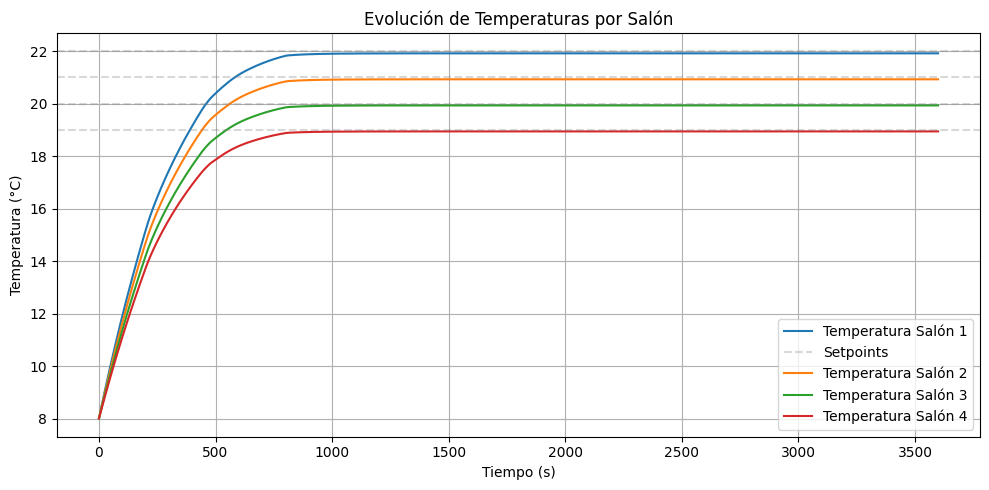

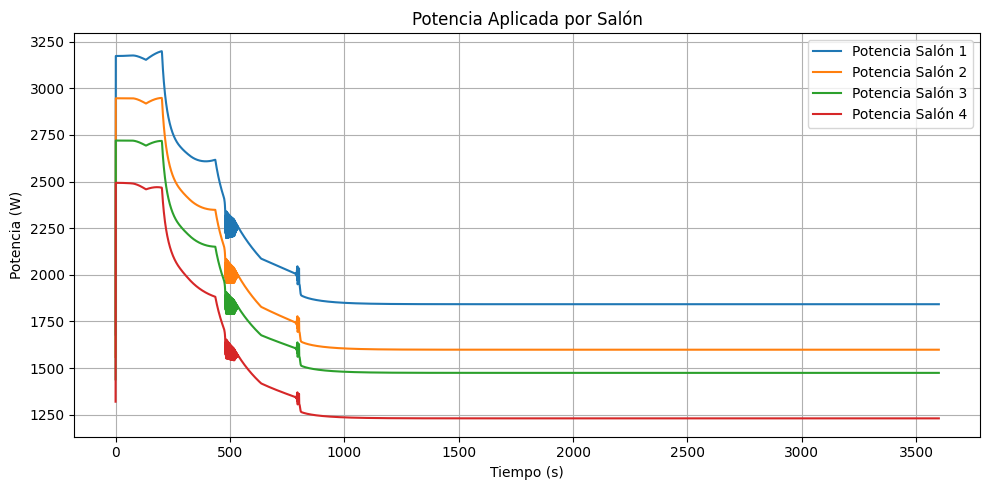

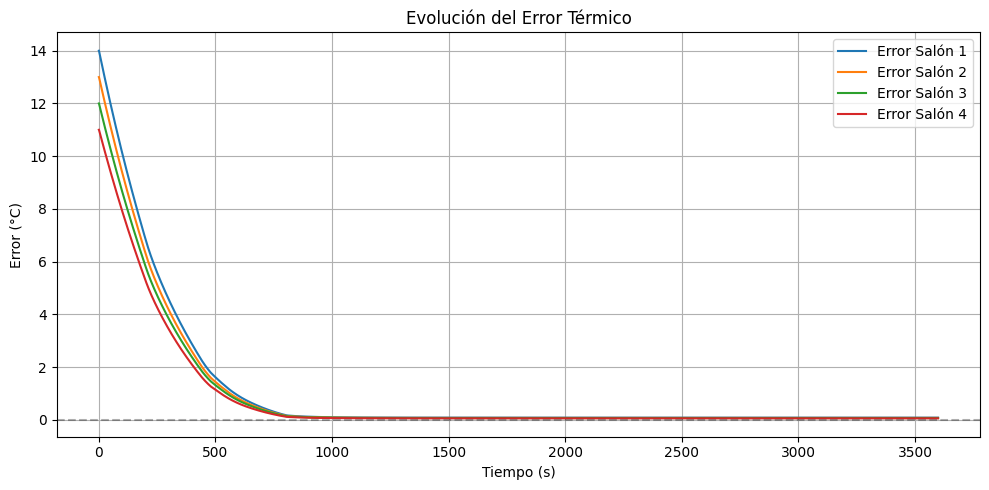

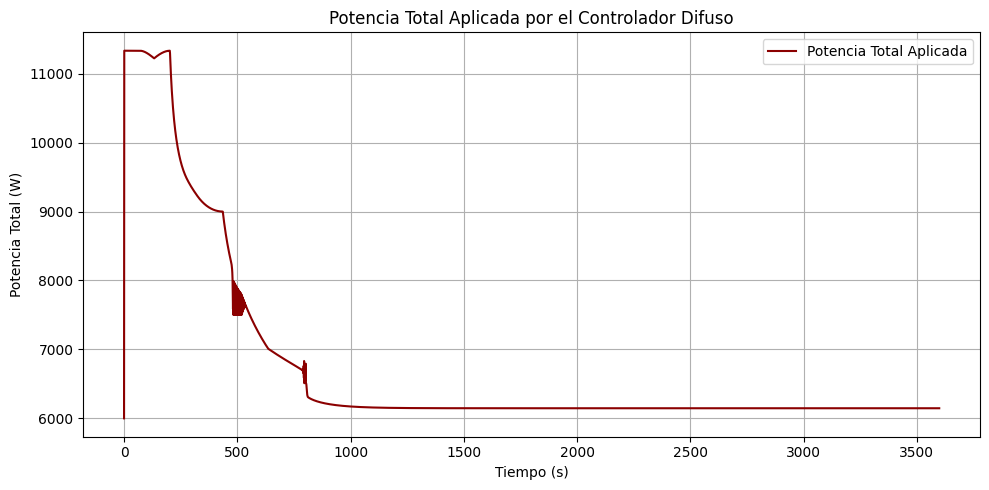

In [15]:
temp_hist = np.array(temp_hist)
error_hist = np.array(error_hist)
potencia_hist = np.array(potencia_hist)
potencia_total_hist = np.array(potencia_total_hist)

# --- Temperaturas por salón ---
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(time, temp_hist[:, i], label=f'Temperatura Salón {i+1}')
    plt.axhline(T_ref[i], color='gray', linestyle='--', alpha=0.3, label=f'Setpoints' if i==0 else "")
plt.title('Evolución de Temperaturas por Salón')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Potencia aplicada por salón ---
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(time, potencia_hist[:, i], label=f'Potencia Salón {i+1}')
plt.title('Potencia Aplicada por Salón')
plt.xlabel('Tiempo (s)')
plt.ylabel('Potencia (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Error térmico por salón ---
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(time, error_hist[:, i], label=f'Error Salón {i+1}')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Evolución del Error Térmico')
plt.xlabel('Tiempo (s)')
plt.ylabel('Error (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Potencia total aplicada ---
plt.figure(figsize=(10, 5))
plt.plot(time, potencia_total_hist, label='Potencia Total Aplicada', color='darkred')
plt.title('Potencia Total Aplicada por el Controlador Difuso')
plt.xlabel('Tiempo (s)')
plt.ylabel('Potencia Total (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Analisis y conclusiones

De los resultados obtenidos se puede concluir que la implementación del controlador fue exitosa, en la primera grafica se puede observar como la temperatura de los 4 salones logra alcanzar el setpoint establecido sin presentar error estacionario, lo cual tambien se puede detallar en la grafica del error te temperatura por salon donde se ve como va decreciendo hasta estabilizarse en 0. Este comportamiendo evidencia que las funciones y reglas establecidas estan definidas correctamente, sobretodo observando que no se presentan tampo oscilaciones y que se alcanza un comportamiento suave y estable durante toda la simulación.

Al observar las graficas de la accion de control, tanto por salon como la potencia total aplicada, se puede evidenciar que no se presentan cambios bruscos salvo en el punto previo a alcanzar el setpoint y que en general tambien se obtiene un comporamiento suave hasta el punto de establecimiento. Tambien de los resultados se puede ver como la potencia total aplicada si llega a alcanzar los 12000 W que se definieron en el rango de la variable aunque por un corto periodo de tiempo mientras que al final de la simulacion y una vez alcanzado el setpoint en los 4 salones la potencia requerida para mantener la temperatura se reduce aproximadamente a la mitad.


Al comparar la implementacion realizada de los dos controladores es calro que el controlador diseñado con logica difusa es mas eficiente, a pesar que al implementar un controlador on/off con histeresis se logran reducir en gran medida las oscilaciones en la temperatura es un comportamiento que no es posible eliminar por la misma naturaleza del controlador de solo encender y apagar la calefacción. Por el contario, con logica difusa fue posible alcanzar un comportamiento correcto y estable con las funciones y reglas definidas donde es importante resaltar que la flexibilidad que se tiene con este controlador permite que entre mayor sea el detalle y los escenarios definidos en los rangos de las variables de entrada y salida se pueden obtener un comportamiento bastante suave y evitando comportamientos abruptos tanto en la variable de control que puedan llevar a oscilaciones o errores en estado estacionario.